# How many beach cleanup events will happen in a region over the next year?

Given the beach cleanup data and a region, we want to predict how many beach cleanup events will happen in that region for the next year.
First, let's load in the data.

In [1]:
import pandas as pd
import sqlite3

with sqlite3.connect('../ocean_plastic.db') as con:
    cleanups = pd.read_sql('select * from plastic_all_data', con)

cleanups

,index,X,Y,OBJECTID,RecordSequenceID,UniqueID,SourceID,LocationFreqID,Location,Dataset,...,CONTINENT,LAND_TYPE,LAND_RANK,Shape__Area,Shape__Length,Count_,Soft_Sheets2,PlasticStraps2,FishingGlowSticks2,FishingOtherPlasticDebris2
0,0,-123.435585,38.690549,1,349,MDP-349,40-3153,Blackpoint Beach (Lon -123.4355847 Lat 38.6905...,"Blackpoint Beach, Sonoma, CA, United States",NOAA MDMAP Accumulation Survey,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
1,1,-123.484406,38.728707,2,351,MDP-351,37-3164,Dune Drift Beach (Lon -123.4844062 Lat 38.7287...,"Dune Drift Beach, Sonoma, CA, United States",NOAA MDMAP Accumulation Survey,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
2,2,-123.456400,38.713200,3,354,MDP-354,59-3175,Ohlson Beach (Lon -123.4564 Lat 38.7132),"Ohlson Beach, Sonoma, CA, United States",NOAA MDMAP Accumulation Survey,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
3,3,-123.490915,38.735105,4,358,MDP-358,41-3191,Walk On Beach (Lon -123.490915 Lat 38.735105),"Walk On Beach, Sonoma, CA, United States",NOAA MDMAP Accumulation Survey,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
4,4,-124.462100,42.714900,5,360,MDP-360,11-3195,Rocky Point (Lon -124.4621 Lat 42.7149),"Rocky Point, Curry, OR, United States",NOAA MDMAP Accumulation Survey,...,North America,Primary land,5.0,28.117307,33.913945,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54383,54383,-124.100770,41.252420,54876,61765,TID-56239,109776,TIDES (Lon -124.10076984714 Lat 41.252418056585),"Humboldt County, CA, USA",Oecan Conservancy TIDES Report,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
54384,54384,-124.163890,40.863150,54877,61766,TID-56240,109777,TIDES (Lon -124.16388963357 Lat 40.863149441367),"Humboldt County, CA, USA",Oecan Conservancy TIDES Report,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
54385,54385,-124.149530,40.865560,54878,61767,TID-56241,109779,TIDES (Lon -124.14953098159 Lat 40.865556085634),"Humboldt County, CA, USA",Oecan Conservancy TIDES Report,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0
54386,54386,-124.126110,40.959180,54879,61768,TID-56242,109808,TIDES (Lon -124.12610524606 Lat 40.959183318067),"Humboldt County, CA, USA",Oecan Conservancy TIDES Report,...,North America,Primary land,5.0,41.506355,56.814460,1,0,0,0,0


Restricting ourselves to a single country, let's see if we can predict the number of beach cleanups in the next year by taking the linear regression of the past 2 years.
Note that some countries have very little data if you go back too far; for example, we have almost no data for Malaysia before 2018.

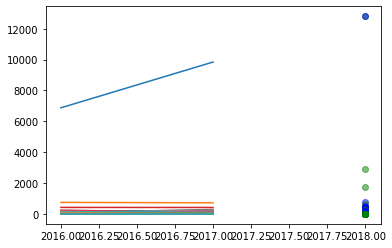

In [2]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

year_to_forecast = 2018
accuracies = []

for country, number_of_cleanups in cleanups.loc[:, 'COUNTRY'].value_counts().items():
    try:
        x = cleanups.loc[(cleanups.loc[:, 'Year'] < year_to_forecast) & (cleanups.loc[:, 'Year'] >= year_to_forecast - 2) & (cleanups.loc[:, 'COUNTRY'] == country)]
        y = len(cleanups.loc[(cleanups.loc[:, 'Year'] == year_to_forecast) & (cleanups.loc[:, 'COUNTRY'] == country)])
        plt.plot(x.loc[:, 'Year'].value_counts().keys(), x.loc[:, 'Year'].value_counts().values)
        plt.scatter(year_to_forecast, y, color='Green', alpha=0.5);
        x1, x2 = x.loc[:, 'Year'].value_counts()
        prediction = x1 + (x1-x2)
        plt.scatter(year_to_forecast, prediction, color='Blue', alpha=0.5)
        accuracy = 100 * (1 - abs((prediction - y) / y))
        accuracies.append((accuracy, country))
    except:
        pass

Now, let's plot the accuracies.

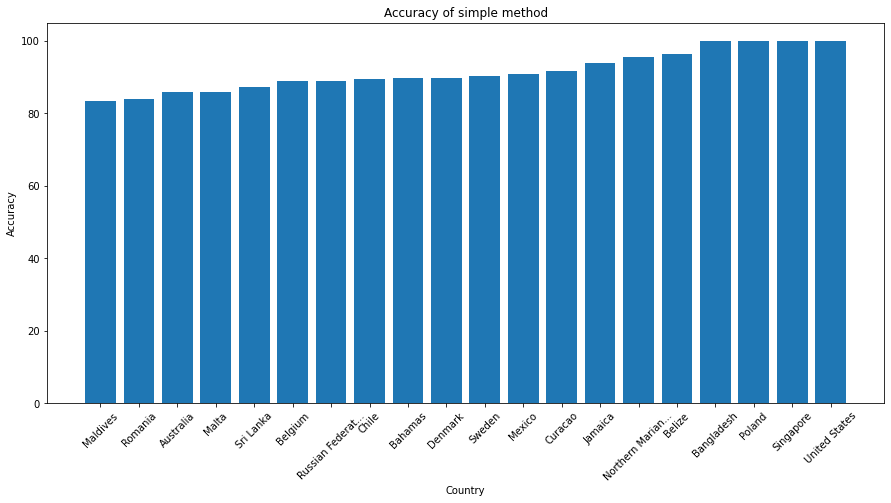

In [3]:
accuracies = sorted(accuracies)
best = accuracies[-20:]
performances, countries = list(zip(*best))
countries = [country[:15] + ('...' if len(country) > 15 else '') for country in countries]
plt.figure(figsize=(15, 7))
plt.title('Accuracy of simple method')
plt.bar(countries, performances)
plt.xlabel('Country')
plt.ylabel('Accuracy')
plt.xticks(rotation=45);